In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Linear Regression Inference

## What will we accomplish

In this notebook we will discuss
- Using `statsmodels` instead of `sklearn` for inference.
- Hypothesis tests for nested linear model comparison.
    - $H_0$ is the claim that the $y_i$ are generated by a linear model using some particular subset of the features.
    - $H_a$ is the claim that the $y_i$ are generated using more of the features than just that subset.
    - A common special case is when $H_0$ involves omitting a *single* feature.  This is what is usually meant by "we found this feature to have a statistically significant correlation with the outcome".
- Confidence intervals for conditional outcome means.
    - These are confidence intervals for $\mathbb{E}(Y | \textbf{x})$.
- Prediction intervals for conditional outcomes.
    - These are confidence intervals for $Y| \textbf{x}$.

Note:  I am a big fan of Cosma Shalizi.  They have two great free books which address this content:  
- [The Truth About Linear Regression](https://www.stat.cmu.edu/~cshalizi/TALR/) 
- [Advanced Data Analysis from an Elementary Point of View](https://www.stat.cmu.edu/~cshalizi/ADAfaEPoV/).

I will refer to these two texts as TALR and ADA respectively when referencing them in these notes.

## Using `statsmodels` instead of `sklearn` for inferential statistics

As noted in this [GitHub issue](https://github.com/scikit-learn/scikit-learn/issues/6773):

> the scope of scikit-learn is really predictive models, whereas the
confidence intervals, p-values and related are in the scope of
statsmodels.

We will use the right tool for the right job!  

We will use statsmodels which is a Python library for statistical computing.  If you are doing a lot of this kind of work it might be worth learning R (a programming language for statistical computing and data visualization), which supports a superset of what statsmodels supports.

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Hypothesis tests for nested linear models



### The Variance Ratio test ($F$-test) for multiple coefficients being zero.

We are regressing $Y$ on features $X_1, X_2, ..., X_p$.  We want to test whether all of them are actually needed. To be precise:

$$
\begin{align*}
H_0 : Y &= \beta_0 + \beta_1 X_1 + ... + \beta_q X_q + 0 x_{q+1} + \dots + 0 X_p + \epsilon\\
H_a : Y &= \beta_0 + \beta_1 X_1 + ... + \beta_q X_q + \beta_{q+1} X_{q+1} + \dots + \beta_p X_p + \epsilon
\end{align*}
$$

with $\epsilon \sim \mathcal{N}(0,\sigma^2)$.

It turns out that we can use a test statistic of the form:

$$
F = \frac{(\hat{\sigma}_0^2 - \hat{\sigma}_a^2) / (p-q)}{\hat{\sigma}_a^2/ (n - p - 1)}
$$

Under the null hypothesis it can be shown that $F \sim  F_{p-q, n-p-1}$  where the latter is [Snedecor's F-distribution](https://en.wikipedia.org/wiki/F-distribution) $F_{d_1,d_2} \sim \frac{U_1/d_1}{U_2/d_2}$, where $U_1$ and $U_2$ are independent $\chi^2$ distributions with $d_1$ and $d_2$ degrees of freedom respectively.  See TALR chapter 16 for a detailed derivation!

Let's simulate!  We will play with an example where $p = 2$ and $q = 1$.  Let's first simulate an example where $H_a$ is actually true:

In [3]:
# Step 1: Simulate data
np.random.seed(215)
n = 10  # sample size
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

# True model: Y depends on both X1 and X2
Y = 2 + 3 * X1 + 1.5 * X2 + epsilon

# Fit the full and reduced models

# Note:  I am using statsmodel formulas here, which are similar to R style formulas.
# You could instead build the relevant design matrices (including a column of ones!) and use sm.OLS(Y,X).fit()

# Full model: Y ~ X1 + X2
data = {'Y': Y, 'X1': X1, 'X2': X2}
full_model = smf.ols('Y ~ X1 + X2', data=data).fit()

# Reduced model: Y ~ X1
reduced_model = smf.ols('Y ~ X1', data=data).fit()

# Step 3: Perform the F-test
f_test = full_model.compare_f_test(reduced_model)

# Print the results
print("F-statistic:", f_test[0])
print("p-value:", f_test[1])

F-statistic: 7.176509243013829
p-value: 0.03158953432802331


This $p$ value should be interpreted as follows:

> If my data generated process was actually $Y = \beta_0 + \beta_1 X_1 + \epsilon$, and I took lots of random samples with the same $n = 10$, I would only expect around $3\%$ of them to show *this much* improvement when I instead fit the model $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$. 
>
>Since this is an especially rare thing to happen, it gives me some evidence that I should reject the null hypothesis.

Let's also plot the corresponding F-distribution:

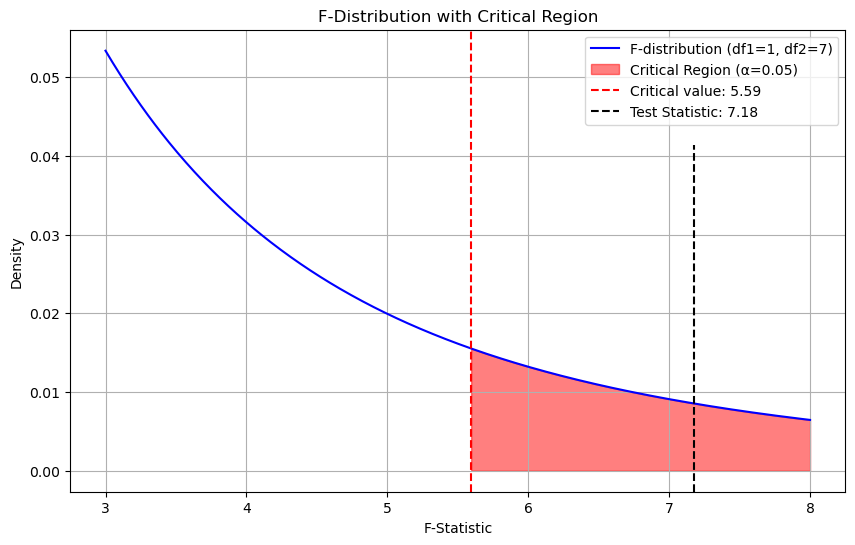

In [4]:
from scipy.stats import f

p = 2
q = 1
dof_numerator = p - q  
dof_denominator = n - p - 1

alpha = 0.05

# F-distribution range
x = np.linspace(3, 8, 500)
y = f.pdf(x, dof_numerator, dof_denominator)

# Critical value
f_critical = f.ppf(1 - alpha, dof_numerator, dof_denominator)

# Plotting the F-distribution
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', label=f'F-distribution (df1={dof_numerator}, df2={dof_denominator})')

# Highlight the critical region
plt.fill_between(x, 0, y, where=(x >= f_critical), color='red', alpha=0.5, label=f'Critical Region (α={alpha})')

# Mark the critical value
plt.axvline(x=f_critical, color='red', linestyle='--', label=f'Critical value: {f_critical:.2f}')

# Mark the F-statistic we obtained
plt.axvline(
    x=f_test[0],
    ymin = 0,
    ymax = 0.75, 
    color='black', 
    linestyle='--', 
    label=f'Test Statistic: {f_test[0]:.2f}'
            )

# Labels and title
plt.title('F-Distribution with Critical Region')
plt.xlabel('F-Statistic')
plt.ylabel('Density')
plt.legend(loc = 'upper right')

# Display the plot
plt.grid(True)
plt.show()

Now let's do an identical analysis, but when the null hypothesis is actually true:

In [5]:
# Step 1: Simulate data
np.random.seed(216)
n = 10  # sample size
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
epsilon = np.random.normal(0, 1, n)

# True model: Y depends on both X1 and X2
Y = 2 + 3 * X1 + epsilon

# Step 2: Fit the full and reduced models
# Full model: Y ~ X1 + X2
data = {'Y': Y, 'X1': X1, 'X2': X2}
full_model = smf.ols('Y ~ X1 + X2', data=data).fit()

# Reduced model: Y ~ X1
reduced_model = smf.ols('Y ~ X1', data=data).fit()

# Step 3: Perform the F-test
f_test = full_model.compare_f_test(reduced_model)

# Print the results
print("F-statistic:", f_test[0])
print("p-value:", f_test[1])

F-statistic: 2.5173643399002126
p-value: 0.15661966975627944


This $p$ value should be interpreted as follows:

> If my data generated process was actually $Y = \beta_0 + \beta_1 X_1 + \epsilon$, and I took lots of random samples with the same $n = 10$, I would  expect around $15.6\%$ of them to show *this much* improvement when I instead fit the model $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$.  
>
>Since that is not an especially rare thing to happen, this doesn't give me much evidence that I should reject the null hypothesis.

#### An important note on interpreting these F-tests!

The full model will *always* fit the data better than the restricted model.

1. The proper interpretation of this test is "How rare would it be for the full model to fit *this much better* under the null hypothesis that the data was actually generated by the restricted model?".
2. This is a comparison between regressing on  $X_1, ..., X_p$ vs. regressing on $X_1, ..., X_q$.  It is possible that one (or more!) of the covariates would be considered significant if our full model only added this one variable instead of all $p-q$ of them.
3. We shouldn't use statistical significance as a guide to what variables to include in our model for predictive purposes.  We should use cross validation for that!
4. It is possible that the model is mis-specified.  Maybe the true relationship is nonlinear, or the most important features have been omitted!
5. This also relies on the assumption of i.i.d. Gaussian errors.

### Many common hypothesis tests are special cases of this F-test for nested linear models.

1. The various $t$-tests for sample means can be viewed as linear regression using a single binary dummy variable for one category.  We are comparing the nested models where we include or do not include this dummy variable.
2. One way and two way ANOVA are linear regressions using categorical variables.  "Two way" ANOVA includes interaction terms while "one way" ANOVA does not.
3. The $p$-values associated with each covariate of a linear model are really the $F$-test comparing the full model to the reduced model with that one covariate omitted.

We will give examples of $1$ and $3$ from this list using the `Howell1` dataset:

> "The data contained in data (Howell1) are partial census data for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s."

I obtained this dataset from the [GitHub repo](https://github.com/rmcelreath/rethinking) associated with the textbook "Statistical Rethinking" by Richard McElreath.

Note:  I got the idea to present these tests as special cases of the linear model from a [blog post](https://lindeloev.github.io/tests-as-linear/) of Jonas Kristoffer Lindeløv.

#### t-test for two sample means



In [6]:
howell = pd.read_csv('../data/howell1.csv')
howell.sample(5)

,height,weight,age,male
386,155.5750,45.529297,21.0,0
13,149.9000,47.700000,20.0,0
79,149.8600,37.931631,46.0,0
421,156.2100,39.292407,26.0,1
337,140.6398,28.859791,12.0,1


We are interested in the weight difference between male and female adult Dobe area !Kung San people in the 60s.  We will define "adult" as being age 18 or older.

The most basic analysis we could run is:

$$
\begin{align*}
H_0 : \textrm{Weight} &= \beta_0 + \epsilon\\
H_a : \textrm{Weight} &= \beta_0 + \beta_1 \textrm{Male} + \epsilon
\end{align*}
$$

Note that $\textrm{Male}$ is a one-hot encoded categorical variable here!

First let's visualize the distribution of weights for males and females using a raincloud plot:

In [7]:
howell = howell[howell.age >= 18] # restricting ourselves to the adult population.

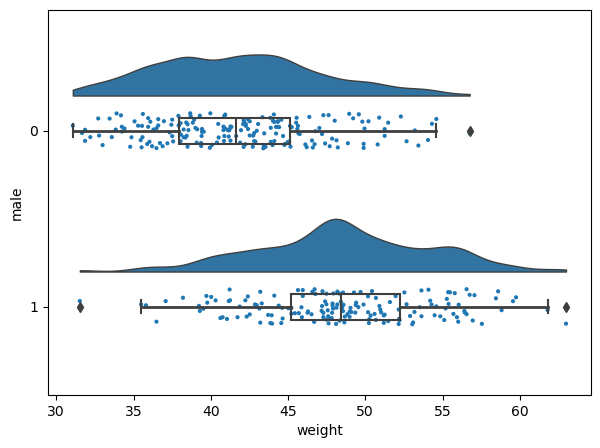

In [8]:
import seaborn as sns
import ptitprince as pt

f, ax = plt.subplots(figsize=(7, 5))

dy="group"; dx="score"; ort="h"; pal = sns.color_palette(n_colors=1)

pt.RainCloud(x = 'male', y = 'weight', data = howell, palette = pal, bw = .2,
                 width_viol = .6, ax = ax, orient = 'h')

plt.show()

While it appears that the mean weight is larger for males we want to know if this difference is statistically significant at $\alpha = 0.05$.  We can do this using a $t$-test for two independent samples:

In [9]:
from scipy import stats

males = howell[howell.male == 1].weight
females = howell[howell.male == 0].weight
t_test_results = stats.ttest_ind(males, females)
t_test_results

TtestResult(statistic=11.523556133876301, pvalue=2.887605558974954e-26, df=350.0)

Let's compare this to the results generated by using the $F$-test:

In [10]:
# Full model: W ~ H
data = {'W': howell.weight, 'H': howell.male}
full_model = smf.ols('W ~ H', data=data).fit()

# Reduced model: Y ~ 1
reduced_model = smf.ols('W ~ 1', data=data).fit()

# Perform the F-test
f_test = full_model.compare_f_test(reduced_model)

# Compare the F-test and t-test results
print("The p-value for the F-test and t-test are identical")
print("F-test p-value:", f_test[1])
print("t-test p-value:", t_test_results[1])
print("")
print("In the special case we are considering the F-statistic is the square of the t-statistic")
print(f"F-statistic: {f_test[0]}")
print(f"Squared t-statistic: {t_test_results[0]**2}")


The p-value for the F-test and t-test are identical
F-test p-value: 2.887605558975095e-26
t-test p-value: 2.887605558974954e-26

In the special case we are considering the F-statistic is the square of the t-statistic
F-statistic: 132.7923459705984
Squared t-statistic: 132.79234597059812


In [11]:
# We can get confidence intervals this way:

full_model.conf_int()

,0,1
Intercept,41.022389,42.605991
H,5.619597,7.932597


In [12]:
# We could also do it this equivalent way:

t_test_results.confidence_interval(0.95)

ConfidenceInterval(low=5.619597028817701, high=7.932596573321327)

So the $95\%$ confidence interval for the difference in the mean weight between males and females is $(5.62, 7.93)$.

What if we wanted to know whether males are significantly heavier than females of the same height?  We by including height as a covariate in our analysis.

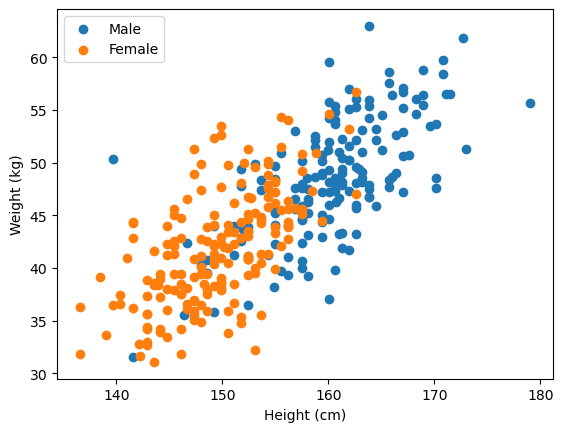

In [13]:
male_howell = howell[howell.male == 1]
female_howell = howell[howell.male == 0]

plt.scatter(male_howell.height, male_howell.weight, label = 'Male')
plt.scatter(female_howell.height, female_howell.weight, label = 'Female')

# Labels and title
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)')
plt.legend(loc = 'upper left')

plt.show()

To me it is hard to tell whether sex is having an impact on the height vs. weight relationship.  Eyeballing it looks as if women might be slightly heavier than men at the same height?  Let's see whether such a difference is statistically significant at $\alpha = 0.05$.

Let's compare two nested models to see whether this apparent difference is statistically significant:

$$
\begin{align*}
H_0 : \textrm{Weight} &= \beta_0 + \beta_1\textrm{Height} + \epsilon\\
H_a : \textrm{Weight} &= \beta_0 + \beta_1 \textrm{Height} + \beta_2 \textrm{Male} + \epsilon
\end{align*}
$$


In [14]:
# Full model: W ~ H + M
data = {'W': howell.weight, 'M': howell.male, 'H': howell.height}
full_model = smf.ols('W ~ H + M', data=data).fit()

# Reduced model: W ~ H
reduced_model = smf.ols('W ~ H', data=data).fit()

# Step 3: Perform the F-test
f_test = full_model.compare_f_test(reduced_model)

# Compare the F-test and t-test results
print("F-test p-value:", f_test[1])

F-test p-value: 0.8775738853328412


This $p$-value should be interpreted as follows:

> If my data generated process was actually $\textrm{Weight} = \beta_0 + \beta_1\textrm{Height} + \epsilon$, and I took lots of random samples with the same number of samples, I would expect around $87.7\%$ of them to show *this much* improvement when I instead fit the model $\textrm{Weight} = \beta_0 + \beta_1\textrm{Height} + \beta_2 \textrm{Male} + \epsilon$.  
>
>Since that is not an especially rare thing to happen, this doesn't give me much evidence that I should reject the null hypothesis.

Let's take a look at the summary of the full model:

In [15]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     231.0
Date:                Thu, 29 Aug 2024   Prob (F-statistic):           1.25e-64
Time:                        13:58:29   Log-Likelihood:                -1007.1
No. Observations:                 352   AIC:                             2020.
Df Residuals:                     349   BIC:                             2032.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -52.9543      6.139     -8.626      0.000     -65.028     -40.881
H              0.6338      0.041     15.458      0.000       0.553       0.714
M             -0.0979      0.635     -0.154      0.878      -1.347       1.152
==============================================================================
Omnibus:                        5.798   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.552
Skew:                           0.291   Prob(JB):                       0.0623
Kurtosis:                       3.199   Cond. No.                     4.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Notice that the $p$-value for $M$ is exactly the $p$-value we got by comparing nested models. 

This is true in general:  when you see a $p$-value associated to a single covariate, what is meant is the $p$-value when comparing the full model to the resticted model with *only* that one covariate omitted.

It is important to realize that the $p$-value associated with a covariate depends on all of the *other* covariates you have included in your model.  It is certainly possible that a covariate which is not statistically significant could become so when another covariate is dropped!

## Confidence Intervals vs. Prediction Intervals for outcomes

If we have fit a model $Y = \beta \cdot \textbf{X} + \epsilon$ and have a new input $\textbf{x}$ there are two different questions we can ask about the outcome:

1.  What is the confidence interval on $\mathbb{E}(Y | \textbf{x})$?
    * The answer to this question is called the *confidence interval for the conditional outcome mean*.
2.  What is the confidence interval on $Y | \textbf{x}$?
    * The answer to this question is called the *prediction interval for the conditional outcome*.

The confidence interval and prediction interval will both center around our predicted value, but the confidence interval will be narrower than the prediction interval:

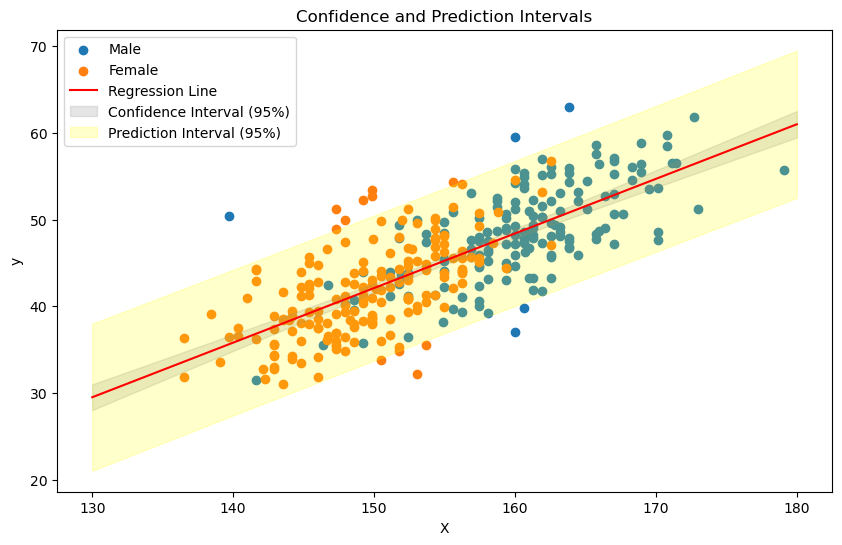

In [16]:
xs = np.linspace(130, 180)

# Create a DataFrame with the same structure as the one used for training
df_xs = pd.DataFrame({'H': xs})

# Get predictions using the new DataFrame
predictions = reduced_model.get_prediction(df_xs)

pred_summary_frame = predictions.summary_frame(alpha=0.05)

# Extract values
mean_pred = pred_summary_frame['mean']
mean_ci_lower = pred_summary_frame['mean_ci_lower']
mean_ci_upper = pred_summary_frame['mean_ci_upper']
obs_ci_lower = pred_summary_frame['obs_ci_lower']
obs_ci_upper = pred_summary_frame['obs_ci_upper']

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(male_howell.height, male_howell.weight, label = 'Male')
plt.scatter(female_howell.height, female_howell.weight, label = 'Female')

plt.plot(xs, mean_pred, 'r-', label='Regression Line')
plt.fill_between(xs, mean_ci_lower, mean_ci_upper, color='gray', alpha=0.2, label='Confidence Interval (95%)')
plt.fill_between(xs, obs_ci_lower, obs_ci_upper, color='yellow', alpha=0.2, label='Prediction Interval (95%)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Confidence and Prediction Intervals')
plt.show()


Note that both the confidence and prediction bands are not of constant width!  You can understand this by imagining varying both the slope and intercept a small amount.